<a href="https://colab.research.google.com/github/kimwoonggon/publicservant_AI/blob/master/05_%EC%BC%80%EB%9D%BC%EC%8A%A4%EB%A1%9C_KorQuAD(%ED%95%9C%EA%B5%AD%EC%96%B4_Q%26A)_%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><strong>케라스로 KorQuAD 구현하기</strong></h1>
<h1><strong><u>Youtube 공무원AI</u></strong></h1>

![대체 텍스트](https://i.imgur.com/XSuDmcC.png)

이번 튜토리얼에서는 케라스와 BERT를 활용하여 <strong>KorQuAD</strong>를 구현해보고자 합니다. 이전에 배웠던 SQuAD와의 차이점은 단지 파일이 다르다는 점과,
Tokenize를 정의할 때 네이버 한국어 영화 감성분석 할때처럼 새로운 Tokenize를 정의해서 한다는 점 말고는 SQuAD 랑 완전히 동일합니다.


In [0]:
# wget을 활용해서 bert 모델 다운로드 가능
!wget https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip

--2020-02-05 00:55:59--  https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 2a00:1450:4013:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662903077 (632M) [application/zip]
Saving to: ‘multi_cased_L-12_H-768_A-12.zip’

multi_cased_L-12_H- 100%[===================>] 632.19M  74.0MB/s    in 9.2s    

2020-02-05 00:56:09 (68.5 MB/s) - ‘multi_cased_L-12_H-768_A-12.zip’ saved [662903077/662903077]



In [0]:
import os
if "bert" not in os.listdir():
  os.makedirs("bert")
else:
  pass

import zipfile
import shutil
         
bert_zip = zipfile.ZipFile('multi_cased_L-12_H-768_A-12.zip')
bert_zip.extractall('bert')
 
bert_zip.close()

In [0]:
def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

copytree("bert/multi_cased_L-12_H-768_A-12", "bert")

In [0]:
!wget https://raw.githubusercontent.com/nate-parrott/squad/master/data/train-v1.1.json
!wget https://raw.githubusercontent.com/nate-parrott/squad/master/data/dev-v1.1.json

--2020-02-05 00:56:43--  https://raw.githubusercontent.com/nate-parrott/squad/master/data/train-v1.1.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30288272 (29M) [text/plain]
Saving to: ‘train-v1.1.json’

train-v1.1.json     100%[===================>]  28.88M  --.-KB/s    in 0.1s    

2020-02-05 00:56:43 (272 MB/s) - ‘train-v1.1.json’ saved [30288272/30288272]

--2020-02-05 00:56:47--  https://raw.githubusercontent.com/nate-parrott/squad/master/data/dev-v1.1.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4854279 (4.6M) [text/pl

In [0]:
os.listdir()

['.config',
 'bert',
 'train-v1.1.json',
 'dev-v1.1.json',
 'multi_cased_L-12_H-768_A-12.zip',
 'sample_data']


##**구글 드라이브와 Colab을 연동합니다**

In [0]:
import os
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
path = "gdrive/My Drive/Colab Notebooks/squad"

<h2><strong>본격적으로 케라스와 버트를 활용하여 KorQUAD 예측 모델을 만들어 보겠습니다.</strong></h2>

텐서플로우, 판다스, 넘파이, 케라스 등 필요한 모듈들을 임포트합니다

In [0]:
# 텐서플로우 1 기반임
%tensorflow_version 1.x
import tensorflow as tf

import pandas as pd
import numpy as np  
import re
import pickle

import keras as keras
from keras.models import load_model
from keras import backend as K
from keras import Input, Model
from keras import optimizers

from keras import backend as K
from keras.layers import Layer

import codecs
from tqdm import tqdm
import shutil
import json

Using TensorFlow backend.


In [0]:
import warnings
import tensorflow as tf
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.logging.set_verbosity(tf.logging.ERROR)

케라스에서 Bert 활용을 쉽게 만들어주는 모듈 keras-bert를 설치합니다<br>그리고 Adam optimizer의 수정판인 keras-radam 모듈을 임포트합니다.

In [0]:
!pip install keras-bert
!pip install keras-radam

  Created wheel for keras-bert: filename=keras_bert-0.81.0-cp36-none-any.whl size=37913 sha256=c69491853cb58f851eb77001afb9d61223722c80a150c7c6bc0fca696f8c551e
  Stored in directory: /root/.cache/pip/wheels/bd/27/da/ffc2d573aa48b87440ec4f98bc7c992e3a2d899edb2d22ef9e
  Created wheel for keras-transformer: filename=keras_transformer-0.32.0-cp36-none-any.whl size=13266 sha256=d1f147878d4ccbd56546c07c1d7a30961d2b769b54cdb103c3d6dcb0e3f0d3f9
  Stored in directory: /root/.cache/pip/wheels/62/f0/ce/82fa5d024d5ef8e263f26a50dcee23820efe245680ce9c922a
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp36-none-any.whl size=7554 sha256=32e52a9f10f5a58a54f14501d883c3c286bbf209bb37fcc19070594761367016
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
  Created wheel for keras-multi-head: filename=keras_multi_head-0.22.0-cp36-none-any.whl size=15371 sha256=77142b5bbd33dea58170799a727d6c84c07d1b7d9c789baff6fc1cebb2e8b911
  Stor

keras-bert 라이브러리에서 버트 모형 활용에 필요한 모듈들을 임포트합니다

In [0]:
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

from keras_radam import RAdam

SQUAD JSON파일을 PANDAS DATAFRAME으로 만들어주는 함수를 정의합니다. 

KorQuAD도 SQUAD랑 동일한 방식이기에, Pandas Dataframe으로 잘 변환 됩니다. 
출처 : https://www.kaggle.com/sanjay11100/squad-stanford-q-a-json-to-pandas-dataframe

In [0]:
def squad_json_to_dataframe_train(input_file_path, record_path = ['data','paragraphs','qas','answers'],
                           verbose = 1):
    """
    input_file_path: path to the squad json file.
    record_path: path to deepest level in json file default value is
    ['data','paragraphs','qas','answers']
    verbose: 0 to suppress it default is 1
    """
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(input_file_path).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.io.json.json_normalize(file , record_path )
    m = pd.io.json.json_normalize(file, record_path[:-1] )
    r = pd.io.json.json_normalize(file,record_path[:-2])
    
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    ndx  = np.repeat(m['id'].values,m['answers'].str.len())
    m['context'] = idx
    js['q_idx'] = ndx
    main = pd.concat([ m[['id','question','context']].set_index('id'),js.set_index('q_idx')],1,sort=False).reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

KorQUAD 데이터를 PANDAS DATAFRAME 형식으로 로드합니다.

In [0]:
train = squad_json_to_dataframe_train(path+"/KorQuAD_v1.0_train.json")

Reading the json file
processing...
shape of the dataframe is (60407, 6)
Done


In [0]:
train

,index,question,context,text,answer_start,c_id
0,6566495-0-0,바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,교향곡,54,0
1,6566495-0-1,바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,1악장,421,0
2,6566495-0-2,바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,베토벤의 교향곡 9번,194,0
3,6566518-0-0,1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,파우스트,15,0
4,6566518-0-1,파우스트 서곡의 라단조 조성이 영향을 받은 베토벤의 곡은?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,합창교향곡,354,0
...,...,...,...,...,...,...
60402,6467478-1-1,뉴델리 메탈로 베타락마제가 처음 감염 된 지역은 어디인가?,"유전자의 이름은 인도의 수도 뉴델리의 이름을 따 붙여졌는데, 이는 2009년 용 (...",인도,73,9604
60403,6467478-2-0,균은 유전자를 균에게 전달 할 수있는데 이러한 현상을 나타낸 용어는 무엇인가?,"2010년 8월, 저널 The Lancet Infectious Diseases에 최...",유전자 전달,253,9605
60404,6467478-2-1,박테리아가 NDM-1 유전자를 가지고 있을때 발생하는 전파를 분석하기위해 사용된 영...,"2010년 8월, 저널 The Lancet Infectious Diseases에 최...",37건,129,9605
60405,6490801-2-0,NDM-1 유전자를 가진 박테리아가 감수성을 보인 폴리믹슨 계열 항생제는?,"2010년 8월, 저널 The Lancet Infectious Diseases에 최...",콜리스틴,404,9605



- bert 훈련을 위한 사전 설정을 합니다. SEQ_LEN은 문장의 최대 길이입니다. SEQ_LEN 보다 문장의 길이가 작다면 남은 부분은 0이 채워지고, 만약에 SEQ_LEN보다 문장 길이가 길다면 SEQ_LEN을 초과하는 부분이 잘리게 됩니다.  
본 문제에서는 메모리 문제 등으로 384로 정했습니다.
- BATCH_SIZE는 메모리 초과 같은 문제를 방지하기 위해 작은 수인 10으로 정했습니다. 그리고 총 훈련 에포크 수는 1로 정했습니다. 학습율(LR;Learning rate)은 3e-5로 작게 정했습니다.
- pretrained_path는 bert 사전학습 모형이 있는 폴더를 의미합니다.
- 그리고 우리가 분석할 문장이 들어있는 칼럼의 제목인 document와 긍정인지 부정인지 알려주는 칼럼을 label로 정해줍니다


In [0]:
SEQ_LEN = 384
BATCH_SIZE = 10
EPOCHS=1
LR=3e-5

pretrained_path ="bert"
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

DATA_COLUMN = "context"
QUESTION_COLUMN = "question"
TEXT = "text"

vocab.txt에 있는 단어에 인덱스를 추가해주는 token_dict라는 딕셔너리를 생성합니다.  
우리가 분석할 문장이 토큰화가 되고, 그 다음에는 인덱스(숫자)로 변경되어서 버트 신경망에 인풋으로 들어게 됩니다.

In [0]:
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        if "_" in token:
          token = token.replace("_","")
          token = "##" + token
        token_dict[token] = len(token_dict)

- BERT의 토큰화는 단어를 분리하는 토큰화 방식입니다. wordpiece(단어조각?) 방식이라고 하는데, 이는 한국어를 형태소로 꼭 변환해야 할 문제를 해결해주며, 의미가 있는 단어는 밀접하게 연관이 되게 하는 장점까지 갖추고 있습니다.
- 단어의 첫 시작은 ##가 붙지 않지만, 단어에 포함되면서 단어의 시작이 아닌 부분에는 ##가 붙는 것이 특징입니다.  
- 네이버 감성분석에서 했던 것처럼, 한국어 감성분석에서는 새로 토크나이저 클래스를 상속을 받아서, 토크나이저를 재정의 해주어야 합니다.(그렇지 않으면 완전자모분리 현상 발생)

In [0]:
class inherit_Tokenizer(Tokenizer):
  def _tokenize(self, text):
        if not self._cased:
            text = text
            
            text = text.lower()
        spaced = ''
        for ch in text:
            if self._is_punctuation(ch) or self._is_cjk_character(ch):
                spaced += ' ' + ch + ' '
            elif self._is_space(ch):
                spaced += ' '
            elif ord(ch) == 0 or ord(ch) == 0xfffd or self._is_control(ch):
                continue
            else:
                spaced += ch
        tokens = []
        for word in spaced.strip().split():
            tokens += self._word_piece_tokenize(word)
        return tokens

In [0]:
tokenizer = inherit_Tokenizer(token_dict)

토큰화가 잘 되었는지 확인해 봅니다.
버트 모형은 문장 앞에 꼭 [CLS]라는 문자가 위치하고, [SEP]라는 문자가 끝에 위치합니다.  
[CLS]는 문장의 시작, [SEP]는 문장의 끝을 의미합니다.

In [0]:
print(tokenizer.tokenize("한국어 토큰화."), tokenizer.tokenize("잘되니."))

['[CLS]', '한국', '##어', '토', '##큰', '##화', '.', '[SEP]'] ['[CLS]', '잘', '##되', '##니', '.', '[SEP]']


In [0]:
token_dict

{'[PAD]': 0,
 '[unused1]': 1,
 '[unused2]': 2,
 '[unused3]': 3,
 '[unused4]': 4,
 '[unused5]': 5,
 '[unused6]': 6,
 '[unused7]': 7,
 '[unused8]': 8,
 '[unused9]': 9,
 '[unused10]': 10,
 '[unused11]': 11,
 '[unused12]': 12,
 '[unused13]': 13,
 '[unused14]': 14,
 '[unused15]': 15,
 '[unused16]': 16,
 '[unused17]': 17,
 '[unused18]': 18,
 '[unused19]': 19,
 '[unused20]': 20,
 '[unused21]': 21,
 '[unused22]': 22,
 '[unused23]': 23,
 '[unused24]': 24,
 '[unused25]': 25,
 '[unused26]': 26,
 '[unused27]': 27,
 '[unused28]': 28,
 '[unused29]': 29,
 '[unused30]': 30,
 '[unused31]': 31,
 '[unused32]': 32,
 '[unused33]': 33,
 '[unused34]': 34,
 '[unused35]': 35,
 '[unused36]': 36,
 '[unused37]': 37,
 '[unused38]': 38,
 '[unused39]': 39,
 '[unused40]': 40,
 '[unused41]': 41,
 '[unused42]': 42,
 '[unused43]': 43,
 '[unused44]': 44,
 '[unused45]': 45,
 '[unused46]': 46,
 '[unused47]': 47,
 '[unused48]': 48,
 '[unused49]': 49,
 '[unused50]': 50,
 '[unused51]': 51,
 '[unused52]': 52,
 '[unused53]': 53

token dict의 key 값과 value 값을 바꾼 reverse_token_dict를 정의합니다.

In [0]:
reverse_token_dict = {v : k for k, v in token_dict.items()}

In [0]:
reverse_token_dict

{0: '[PAD]',
 1: '[unused1]',
 2: '[unused2]',
 3: '[unused3]',
 4: '[unused4]',
 5: '[unused5]',
 6: '[unused6]',
 7: '[unused7]',
 8: '[unused8]',
 9: '[unused9]',
 10: '[unused10]',
 11: '[unused11]',
 12: '[unused12]',
 13: '[unused13]',
 14: '[unused14]',
 15: '[unused15]',
 16: '[unused16]',
 17: '[unused17]',
 18: '[unused18]',
 19: '[unused19]',
 20: '[unused20]',
 21: '[unused21]',
 22: '[unused22]',
 23: '[unused23]',
 24: '[unused24]',
 25: '[unused25]',
 26: '[unused26]',
 27: '[unused27]',
 28: '[unused28]',
 29: '[unused29]',
 30: '[unused30]',
 31: '[unused31]',
 32: '[unused32]',
 33: '[unused33]',
 34: '[unused34]',
 35: '[unused35]',
 36: '[unused36]',
 37: '[unused37]',
 38: '[unused38]',
 39: '[unused39]',
 40: '[unused40]',
 41: '[unused41]',
 42: '[unused42]',
 43: '[unused43]',
 44: '[unused44]',
 45: '[unused45]',
 46: '[unused46]',
 47: '[unused47]',
 48: '[unused48]',
 49: '[unused49]',
 50: '[unused50]',
 51: '[unused51]',
 52: '[unused52]',
 53: '[unused53]'

**버트 모형에 들어갈 인풋은 토큰, 세그먼트, 포지션으로 구성됩니다.**  
버트에 인풋으로 들어가는 토큰은 문장을 토크나이징 한 후, 인덱스 번호를 매긴 것입니다.  
세그먼트는 예를 들어 문장이 두 개가 있다면, 앞의 문장과 뒤의 문장을 구분하는 것입니다.  
포지션 임베딩은 단순히 단어의 위치를 말합니다.

토큰, 세그먼트, 포지션을 인풋으로 버트 모형에 넣으면 기하학적인 문장 공간으로 임베딩이 됩니다.  
그림을 보면 my dog is cute, he likes play ##ing 두 문장이 있는데요  
KorQUAD 문제에서는 첫번째 문장이 질문, 두번째 문장이 context가 되고, 이 두 문장이 합쳐져서 하나의 문장으로 들어가게 됩니다.

![대체 텍스트](https://i.imgur.com/l9BTao3.png)

- 사전학습된 버트 모델의 인풋은 문장 토큰화가 숫자로 바뀐 것과, 앞문장인지 뒷문장인지 알려주는 문장 순서 벡터가 들어갑니다. 우리는 문장 하나를 가지고만 훈련할 것이므로 순서 벡터는 모두 0으로 통일합니다.

- 그리고 파인튜닝 시에는 문장 안에 일부 단어를 가리는 마스킹은 사용하지 않습니다.

우리가 로드하였던 KorQUAD 데이터를 **버트 모형의 입력에 맞게 변형해주는 함수**를 정의하도록 하겠습니다.

함수 내부에 tokenizer.encode 함수가 버트 모형을 토큰화해주고 토큰화 된 단어를 인덱스에 맞게 숫자로 바꿔주게 됩니다.  
**[CLS] 질문 [SEP] 문장 [SEP]** 이런 방식으로 질문과 문장이 인풋으로 들어가게 됩니다. SEQ_LEN이 384로 지정되어 있어서 길이가 384가 넘는 인풋은 문장 부분이 잘려서 들어가게 됩니다.  
SQUAD 문제에서 문장(context) 내에 text(정답)이 포함된다고 미리 말씀 드렸는데요, 길이가 384가 넘는 인풋인 경우에 context 내에 정답을 포함하고 있는 context가 잘려서 정답을 포함하지 않는 경우가 생깁니다. 이번 실습에서는 이러한 경우의 인덱스를 del_list로 지정해서, 빼도록 하겠습니다. (숙제로 남겨 두겠습니다.) 

In [0]:
question = train['question'][0]
context = train['context'][0]
text = train['text'][0]

In [0]:
# 질문
question

'바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?'

In [0]:
# 문장
context

'1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.'

In [0]:
# 정답
text

'교향곡'

In [0]:
print(tokenizer.tokenize(question, context))

['[CLS]', '바', '##그', '##너', '##는', '괴', '##테', '##의', '파', '##우스', '##트를', '읽', '##고', '무', '##엇', '##을', '쓰', '##고', '##자', '했', '##는', '##가', '?', '[SEP]', '1839', '##년', '바', '##그', '##너', '##는', '괴', '##테', '##의', '파', '##우스', '##트', '##을', '처음', '읽', '##고', '그', '내', '##용', '##에', '마', '##음', '##이', '끌', '##려', '이를', '소', '##재', '##로', '해', '##서', '하나의', '교', '##향', '##곡', '##을', '쓰', '##려', '##는', '뜻', '##을', '갖', '##는다', '.', '이', '시', '##기', '바', '##그', '##너', '##는', '1838', '##년에', '빛', '독', '##촉', '##으로', '산', '##전', '##수', '##전을', '다', '걲', '##은', '상', '##황', '##이', '##라', '좌', '##절', '##과', '실', '##망', '##에', '가', '##득', '##했으며', '메', '##피', '##스', '##토', '##펠', '##레스', '##를', '만', '##나는', '파', '##우스', '##트', '##의', '심', '##경', '##에', '공', '##감', '##했다', '##고', '한다', '.', '또한', '파', '##리에', '##서', '아', '##브', '##네', '##크', '##의', '지', '##휘', '##로', '파', '##리', '음악', '##원', '관', '##현', '##악', '##단', '##이', '연', '##주', '##하는', '베', '##토', '##벤', '##의', '교', '##향', '##곡', '9'

In [0]:
print(tokenizer.tokenize(text))

['[CLS]', '교', '##향', '##곡', '[SEP]']


우리의 목표는, 질문(question)과 문장(context)를 받아서, 정답(text)를 맞추는 모델을 만드는 것입니다.  
정답을 통째로 맞추는 것이 아니라, **토큰화된 것의 맨 앞 단어와, 맨 뒷 단어입니다.**  
토큰화된 정답은 ['[CLS]', 'saint', 'bern', '##ade', '##tte', 'sou', '##bir', '##ous', '[SEP]'] 인데, 여기서 **saint**에 해당하는 위치와 **##ous**에 해당하는 위치를 맞추는 버트 모형을 파인튜닝 하려 하는 것입니다.  

  그래서 밑에 convert_data 함수에서, 정답(text) 길이만큼 문장(context)를 슬라이딩 하면서 만약에 문장이 정답을 포함하는 위치에 도달하면, 문장에서 정답의 맨 앞이 우리가 예측할 1번째 정답, 정답의 맨 뒤가 우리가 예측할 2번째 정답이 되게 됩니다.

In [0]:
def convert_data(data_df):
    global tokenizer
    indices, segments, target_start, target_end = [], [], [], []
    for i in tqdm(range(len(data_df))):
        
        ids, segment = tokenizer.encode(data_df[QUESTION_COLUMN][i], data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        

        text = tokenizer.encode(data_df[TEXT][i])[0]

        text_slide_len = len(text[1:-1])
        for i in range(1,len(ids)-text_slide_len-1):  
            exist_flag = 0
            if text[1:-1] == ids[i:i+text_slide_len]:
              ans_start = i
              ans_end = i + text_slide_len - 1
              exist_flag = 1
              break
        
        if exist_flag == 0:
          ans_start = SEQ_LEN
          ans_end = SEQ_LEN

        indices.append(ids)
        segments.append(segment)

        target_start.append(ans_start)
        target_end.append(ans_end)

    indices_x = np.array(indices)
    segments = np.array(segments)
    target_start = np.array(target_start)
    target_end = np.array(target_end)
    
    del_list = np.where(target_start!=SEQ_LEN)[0]

    indices_x = indices_x[del_list]
    segments = segments[del_list]
    target_start = target_start[del_list]
    target_end = target_end[del_list]

    train_y_0 = keras.utils.to_categorical(target_start, num_classes=SEQ_LEN, dtype='int64')
    train_y_1 = keras.utils.to_categorical(target_end, num_classes=SEQ_LEN, dtype='int64')
    train_y_cat = [train_y_0, train_y_1]
    
    return [indices_x, segments], train_y_cat

def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    
    
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_df[QUESTION_COLUMN] = data_df[QUESTION_COLUMN].astype(str)


    data_x, data_y = convert_data(data_df)

    return data_x, data_y

In [0]:
train_x, train_y = load_data(train)

100%|██████████| 60407/60407 [01:40<00:00, 601.03it/s]


In [0]:
train_x[0]

array([[   101,   9318,  78136, ...,  12178,   9011,    102],
       [   101,   9318,  78136, ...,   9011, 118783,    102],
       [   101,   9318,  78136, ...,   9011, 118783,    102],
       ...,
       [   101,   9319, 119351, ...,      0,      0,      0],
       [   101,    182,  10162, ...,      0,      0,      0],
       [   101,  19145,  17289, ...,      0,      0,      0]])

In [0]:
train.shape

(60407, 6)

In [0]:
train_x[0].shape ## 데이터 10000개 소실(데이터 10000개를 추가해주려면 별도 작업 필요)

(50609, 384)

#### 이해가 안 가실 수 있는데, 버트 인풋을 문장으로 예를 들어 만들어 보겠습니다.
#### 인풋은 총 2개가 들어갑니다
- **(토큰)** 첫번째 인풋은 토큰화 된 것이 인덱싱되어 숫자로 변환된 것  

- **(세그멘트)** 두번째 인풋은 앞문장인지 뒷문장인지 알려주는 숫자들입니다. 이번 튜토리얼에서는 파인튜닝 과정이라 앞문장 뒷문장 구분을 안하기 때문에 모두 0으로 하였습니다.  

- **(포지션)** 단어 순서에 따라서 자동으로 부여됩니다.


이해가 되셨는지요?  
구글 깃허브에서 다운받았던 사전학습된 모델을 colab으로 로드합니다.  
Training을 False로 두어서 Bert 모델에서, 마지막 트랜스포머 계층까지만 모델이 로드되게 합니다.

In [0]:
layer_num = 12
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training=False,
    trainable=True,
    seq_len=SEQ_LEN,)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 384)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 384)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 384, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 384, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

모델의 구조를 확인합니다.  
총 12층의 트랜스포머 계층이 있음을 확인할 수 있습니다.


Transfer learning을 위해 Custom Layer를 작성해 줍니다.  
NonMasking 함수를 지정해서, Bert 모형의 자체 Masking 된 텐서들을 풀어줘야 합니다.  
이번 튜토리얼에서 만약 NonMasking 클래스를 만들지 않는다면, Bert 모형을 훈련할 수 없습니다.

In [0]:
class NonMasking(Layer):   
    def __init__(self, **kwargs):   
        self.supports_masking = True  
        super(NonMasking, self).__init__(**kwargs)   
  
    def build(self, input_shape):   
        input_shape = input_shape   
  
    def compute_mask(self, input, input_mask=None):   
        return None   
  
    def call(self, x, mask=None):   
        return x   
  
    def get_output_shape_for(self, input_shape):   
        return input_shape  

Keras Custom Layer 두 개를 생성합니다.  
MyLayer_Start는 정답의 첫 번째 단어를 예측하는 것을 담당하고,  
MyLaer_End는 정답의 마지막 단어를 예측하는 것을 담당합니다.  
  
사실 두 레이어는 동일한 역할을 합니다.  
Bert 모형의 마지막 입력을 받아서, (batch_size, 384, 768)의 텐서 모양을 (batch_size, 384, 2)로 만들어주는 텐서를 곱해줍니다.  
이 다음에 i) (batch_size, 384), ii) (batch_size, 384)의 아웃풋을 출력할 수 있게 하나의 텐서를 두개로 잘라줍니다.  
  
왜 끝이 384냐면, 384개의 위치를 예측하기 때문입니다. 단어의 위치의 최대 개수는 384개로 앞서 지정하였습니다.(SEQ_LEN)


In [0]:
class MyLayer_Start(Layer):

    def __init__(self,seq_len, **kwargs):
        
        self.seq_len = seq_len
        self.supports_masking = True
        super(MyLayer_Start, self).__init__(**kwargs)

    def build(self, input_shape):
        
        self.W = self.add_weight(name='kernel', 
                                 shape=(input_shape[2],2),
                                 initializer='uniform',
                                 trainable=True)
        super(MyLayer_Start, self).build(input_shape)

    def call(self, x):
        
        x = K.reshape(x, shape=(-1,self.seq_len,K.shape(x)[2]))
        x = K.dot(x, self.W)
        
        x = K.permute_dimensions(x, (2,0,1))

        self.start_logits, self.end_logits = x[0], x[1]
        
        self.start_logits = K.softmax(self.start_logits, axis=-1)
        
        return self.start_logits

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.seq_len)


class MyLayer_End(Layer):
  def __init__(self,seq_len, **kwargs):
        
        self.seq_len = seq_len
        self.supports_masking = True
        super(MyLayer_End, self).__init__(**kwargs)
  
  def build(self, input_shape):
        
        self.W = self.add_weight(name='kernel', 
                                 shape=(input_shape[2], 2),
                                 initializer='uniform',
                                 trainable=True)
        super(MyLayer_End, self).build(input_shape)

  
  def call(self, x):

        
        x = K.reshape(x, shape=(-1,self.seq_len,K.shape(x)[2]))
        x = K.dot(x, self.W)
        x = K.permute_dimensions(x, (2,0,1))
        
        self.start_logits, self.end_logits = x[0], x[1]
        
        self.end_logits = K.softmax(self.end_logits, axis=-1)
        
        return self.end_logits

  def compute_output_shape(self, input_shape):
        return (input_shape[0], self.seq_len)

BERT 모델을 출력하는 함수를 지정합니다.  
start_answer, end_answer를 예측하게 됩니다.

In [0]:
from keras.layers import merge, dot, concatenate
from keras import metrics
def get_bert_finetuning_model(model):
  inputs = model.inputs[:2]
  dense = model.output
  x = NonMasking()(dense)
  outputs_start = MyLayer_Start(SEQ_LEN)(x)
  outputs_end = MyLayer_End(SEQ_LEN)(x)
  bert_model = keras.models.Model(inputs, [outputs_start, outputs_end])
  bert_model.compile(
      optimizer=RAdam(learning_rate=LR, decay=0.0001),
      loss='categorical_crossentropy',
      metrics=['accuracy'])
  
  return bert_model

**모델의 FLOW를 확인해 보도록 하겠습니다.**

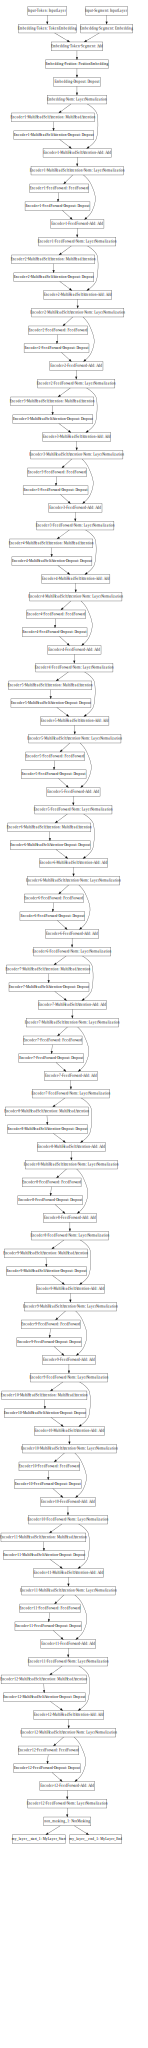

In [0]:
from IPython.display import SVG
from keras.utils import model_to_dot


SVG(model_to_dot(get_bert_finetuning_model(model), dpi=65).create(prog='dot', format='svg'))


훈련을 시작합니다.  
1epoch을 훈련해 보고, 결과를 확인하고 훈련을 다시 시작할 예정입니다.

In [0]:
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init = tf.variables_initializer([v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables])
sess.run(init)

bert_model = get_bert_finetuning_model(model)
bert_model.summary()
history = bert_model.fit(train_x, train_y, batch_size=10, validation_split=0.05, shuffle=False, verbose=1)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 384)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 384)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 384, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 384, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

KeyboardInterrupt: ignored

In [0]:
bert_model = get_bert_finetuning_model(model)
bert_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 384)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 384)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 384, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 384, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

g드라이브상에 squad 모델을 저장할 경로 지정

In [0]:
path = "gdrive/My Drive/Colab Notebooks/squad"

BERT MODEL을 저장합니다.

In [0]:
bert_model.save_weights(path+"/squad_wordpiece.h5")

버트 모형을 다시 훈련합니다.  
이번에는 validation_split을 입력하지 않아서 전체 데이터가 훈련 되도록 만들어 줍니다.

In [0]:
bert_model.compile(optimizer=RAdam(learning_rate=0.00003, decay=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
bert_model.fit(train_x, train_y, batch_size=10, shuffle=False, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
87284/87284 [==============================] - 9501s 109ms/step - loss: 1.0188 - my_layer__start_1_loss: 0.5568 - my_layer__end_1_loss: 0.4620 - my_layer__start_1_acc: 0.8083 - my_layer__end_1_acc: 0.8504


In [0]:
bert_model.save_weights(path+"/squad_wordpiece_2.h5")

버트 모형을 한번 더 훈련시켜 줍니다. learning_rate을 0.00001로 바꿔 줍니다.

In [0]:
bert_model.compile(optimizer=RAdam(learning_rate=0.00001, decay=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
bert_model.save_weights(path+"/squad_wordpiece_3.h5")

재사용을 위해 bert_model을 지드라이브에 저장해줍니다.

버트 모형을 로드해줍니다. 이미 로드하였던 모델에 계수들만 살짝 얹혀 줍니다.

In [0]:
bert_model = get_bert_finetuning_model(model)
bert_model.load_weights(path+"/korquad_wordpiece_3.h5")

Test data set에 대한 bert_input을 만들어 줍니다.  
Train data set과는 다르게 label을 생성하지 않습니다.

In [0]:
def convert_pred_data(question, doc):
    global tokenizer
    indices, segments = [], []
    ids, segment = tokenizer.encode(question, doc, max_len=SEQ_LEN)
    indices.append(ids)
    segments.append(segment)
    indices_x = np.array(indices)
    segments = np.array(segments)
    return [indices_x, segments]

def load_pred_data(question, doc):
    data_x = convert_pred_data(question, doc)
    return data_x

질문과 문장을 받아 답을 알려주는 함수를 정의합니다.

In [0]:
def predict_letter(question, doc):
  
  test_input = load_pred_data(question, doc)
  test_start, test_end = bert_model.predict(test_input)
  
  indexes = tokenizer.encode(question, doc, max_len=SEQ_LEN)[0]
  start = np.argmax(test_start, axis=1).item()
  end = np.argmax(test_end, axis=1).item()
  start_tok = indexes[start]
  end_tok = indexes[end]
  print("Question : ", question)
  
  print("-"*50)
  print("Context : ", end = " ")
  
  def split_text(text, n):
    for line in text.splitlines():
        while len(line) > n:
           x, line = line[:n], line[n:]
           yield x
        yield line

  

  for line in split_text(doc, 150):
    print(line)

  print("-"*50)
  print("ANSWER : ", end = " ")
  print("\n")
  sentences = []
  
  for i in range(start, end+1):
    token_based_word = reverse_token_dict[indexes[i]]
    sentences.append(token_based_word)
    print(token_based_word, end= " ")
  
  print("\n")
  print("Untokenized Answer : ", end = "")
  for w in sentences:
    if w.startswith("##"):
      w = w.replace("##", "")
    else:
      w = " " + w
    
    print(w, end="")
  print("")

KorQUAD 데이터 셋에서 test 용도로 쓰이는 dev 파일을 PANDAS DATAFRAME 형식으로 불러오는 함수를 정의합니다.  
train 데이터와 모양이 약간 다르기 때문에, 함수를 새로 정의해야 합니다.

In [0]:
def squad_json_to_dataframe_dev(input_file_path, record_path = ['data','paragraphs','qas','answers'],
                           verbose = 1):
    """
    input_file_path: path to the squad json file.
    record_path: path to deepest level in json file default value is
    ['data','paragraphs','qas','answers']
    verbose: 0 to suppress it default is 1
    """
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(input_file_path).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.io.json.json_normalize(file , record_path )
    m = pd.io.json.json_normalize(file, record_path[:-1] )
    r = pd.io.json.json_normalize(file,record_path[:-2])
    
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    m['context'] = idx
    main = m[['id','question','context','answers']].set_index('id').reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

In [0]:
input_file_path = path+'/KorQuAD_v1.0_dev.json'
record_path = ['data','paragraphs','qas','answers']
verbose = 0
dev = squad_json_to_dataframe_dev(input_file_path=input_file_path,record_path=record_path)

Reading the json file
processing...
shape of the dataframe is (5774, 5)
Done


TEST DATA가 잘 불려왔는지 확인해 보겠습니다.

In [0]:
dev

,id,question,context,answers,c_id
0,6548850-0-0,임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,"[{'text': '1989년 2월 15일', 'answer_start': 0}]",0
1,6548850-0-1,1989년 6월 30일 평양축전에 대표로 파견 된 인물은?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,"[{'text': '임수경', 'answer_start': 125}]",0
2,6548853-0-0,임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배된 연도는?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,"[{'text': '1989년', 'answer_start': 0}]",0
3,6548853-0-1,임종석을 검거한 장소는 경희대 내 어디인가?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,"[{'text': '학생회관 건물 계단', 'answer_start': 365}]",0
4,6548853-0-2,임종석이 조사를 받은 뒤 인계된 곳은 어딘가?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,"[{'text': '서울지방경찰청 공안분실', 'answer_start': 457}]",0
...,...,...,...,...,...
5769,6511152-4-0,중동 지역에서 갤럭시 S7 엣지가 폭발하는 사건이 발생한 년도는?,2016년 9월 4일 중동 지역에서 갤럭시 S7 엣지가 폭발하는 사건이 발생했다. ...,"[{'text': '2016년', 'answer_start': 0}]",959
5770,6511152-4-1,갤럭시 S7엣지를 만든 회사는?,2016년 9월 4일 중동 지역에서 갤럭시 S7 엣지가 폭발하는 사건이 발생했다. ...,"[{'text': '삼성전자', 'answer_start': 83}]",959
5771,6511152-4-2,2016년 9월 4일 갤럭시 S7엣지가 폭발한 사건이 발생한 지역은?,2016년 9월 4일 중동 지역에서 갤럭시 S7 엣지가 폭발하는 사건이 발생했다. ...,"[{'text': '중동 지역', 'answer_start': 12}]",959
5772,6535617-4-0,갤럭시 노트 7은 출시 며칠만에 기기 결함으로 터지기 시작하였나?,2016년 9월 4일 중동 지역에서 갤럭시 S7 엣지가 폭발하는 사건이 발생했다. ...,"[{'text': '18일', 'answer_start': 286}]",959


테스트 데이터에 대해서 결과를 확인합니다.  
훈련에 사용하지 않은 테스트 데이터에 대한 예측을 제법 잘 수행하는 것을 보실 수 있겠습니다.

In [0]:
import random
for i in random.sample(range(1000),1000):
  doc = dev['context'][i]
  question = dev['question'][i]
  answers = dev['answers'][i]
  predict_letter(question, doc)
  print("")
  print("real answer : ", answers)
  print("")

Question :  소토마요르의 부다페스트 경기 최고 기록은?
--------------------------------------------------
Context :  그해에 열린 국제 아마추어 육상 연맹이 주최한 세계 실내 선수권 대회에서 자신의 첫 시도 2.43m를 제거하면서 기록을 깼다. 이 시합에서 그는 자신이 3위에 서 있던 포인트에서 2.35m를 제거한 4명의 선수들 중의 하나였으며, 자신과 셰베리가 각각 2개의 시도를 필
요할 동안에 그들의 첫 시도들에서 각각 성공한 서독의 디트마르 뫼겐부르크와 영국의 돌턴 그랜트를 추적하였다. 부다페스트에서 소토마요르는 경기의 첫 시도에서 2.31m(7 피트 6.94 인치)을 넘어 2.33m를 통과하고 2.35m(7 피트 8.52 인치)에서 자신의 시
초적인 시도를 놓치다가 두 번째 시도에서 제거하였다. 2.37m(7 피트 9.31 인치)에서 큰 첫 시도 제거를 만들고 2.39m를 통과하여 2.43m(7 피트 11.67 인치)에서 기록 시도를 위해 막대기가 올려졌다. 첫 시도에서 넘어 내려갈 때 자신의 넓적다리의 뒷
부분과 함께 막대기를 스쳐 가면서 제거하였다. 1년 전에 실내 기록 2.42m를 세운 독일의 카를로 타란하르트는 2.33m와 함께 5위로 왔다.
--------------------------------------------------
ANSWER :  

2 . 43 ##m 

Untokenized Answer :  2 . 43m

real answer :  [{'text': '2.43m', 'answer_start': 379}]

Question :  천안함 침몰 원인에 대한 가설 중 내부 충격에 의한 것은?
--------------------------------------------------
Context :  조사단의 공식 조사결과 발표 이전에는 침몰 원인을 두고 다양한 설이 제기되었다. 침몰 원인에는 크게 북한 공격설과 사고설이 있다. 북한 공격설은 어뢰설, 매설기뢰설, 대함화기

한번 만들어진 BERT 모형에 질문을 해 볼까요?  
나무위키에서 데이터를 가져와서 질문을 해보겠습니다.

In [0]:
doc = "태양계의 5번째 행성이며, 태양계의 행성 중 가장 부피가 크고 무겁다. 반지름은 지구의 11.2배, 부피는 지구의 1300배가 넘는다. 질량은 지구의 318배다. 부피에 비해 질량이 작은 이유는 암석형 행성보다 밀도가 낮은 성분들이 주요 구성성분인 가스형 행성이기 때문이다. 그럼에도 목성의 질량은 다른 태양계 행성들을 합친 것보다도 무겁다. 심지어 그 7개 행성의 질량을 몽땅 다 합쳐도 목성의 절반도 되지 않는다. 태양계에서 태양이 99.86%를 차지하고, 목성은 나머지 0.14% 중에서 약 2/3인 0.095%를 차지한다. 뒤를 이어 토성이 0.029%를 차지하며, 나머지 행성들을 모두 합쳐도 태양계 질량의 0.016% 정도 밖에 되지 않는다."
question = "목성의 부피는 지구의 몇배인가?"

predict_letter(question, doc)

In [0]:

doc = "사스와 메르스처럼 코로나 바이러스의 보고되지 않은 종에 인한 감염으로 발생하는 호흡기 질환이다. 최초 발생 원인과 전파 경로는 아직 정확히 밝혀지지 않았다.발병 초기에 보고된 불상의 폐병 증상으로 대중적으로는 '우한 폐렴' 등의 키워드로 불렸으며, 현재 세계보건기구(WHO)에서는 Novel coronavirus(2019-nCoV)라는 표현을 사용 중이다(#). 미국, 영국 등 일부 외신에서는 Wuhan coronavirus라는 표현을 사용하기도 한다. 현재 미국 정부는 질병 명칭에는 Wuhan을 넣지 않은 Coronavirus라고만 지칭 중이다.[11] 대한민국 정부에서 잠정적으로 사용하는 질병 명칭은 신종 코로나바이러스감염증이다. 이는 2015년부터 낙인 효과를 우려한 WHO에서 병명에 지역 이름을 넣는 것을 피하도록 한 권고[12](#)에 따른 것이다. 물론 해당 권고는 구속력이 없으며, 정부나 공공 의료기관이 아닌 일반인, 그리고 언론이 우한 폐렴을 사용하는 것에도 문제가 없다. 실제로 외신이나 당사자인 중국 본토에서도 '우한' 혹은 '중국' 명칭을 사용하고 있다. #기사 사태 초반에는 우한시 안에 국한될 것으로 판단하는 이들이 많았으나, 점차 우한 외 후베이성과 인근 지역, 그리고 중국을 벗어나 해외로까지 퍼지면서 상황이 심각해졌다. 우한시의 인구는 약 1,100만 명이며, 하필 맞물린 춘절[13]로 인한 인구 대이동으로 병이 사방으로 퍼질 위험이 있어 중국 현지에 비상이 걸렸다. 게다가 춘절 기간 중 중국인 관광객들이 해외여행을 많이 가다보니 세계 여러 나라에서도 촉각이 곤두서있다. 따라서 춘절 전후가 감염병 확산의 고비라 할 수 있다."
question = "우한 폐렴은 어디서 발생하였는가?"

predict_letter(question, doc)

Question :  우한 폐렴은 어디서 발생하였는가?
--------------------------------------------------
Context :  사스와 메르스처럼 코로나 바이러스의 보고되지 않은 종에 인한 감염으로 발생하는 호흡기 질환이다. 최초 발생 원인과 전파 경로는 아직 정확히 밝혀지지 않았다.발병 초기에 보고된 불상의 폐병 증상으로 대중적으로는 '우한 폐렴' 등의 키워드로 불렸으며, 현재 세계보건기구(W
HO)에서는 Novel coronavirus(2019-nCoV)라는 표현을 사용 중이다(#). 미국, 영국 등 일부 외신에서는 Wuhan coronavirus라는 표현을 사용하기도 한다. 현재 미국 정부는 질병 명칭에는 Wuhan을 넣지 않은 Coronavirus라고만
 지칭 중이다.[11] 대한민국 정부에서 잠정적으로 사용하는 질병 명칭은 신종 코로나바이러스감염증이다. 이는 2015년부터 낙인 효과를 우려한 WHO에서 병명에 지역 이름을 넣는 것을 피하도록 한 권고[12](#)에 따른 것이다. 물론 해당 권고는 구속력이 없으며, 정
부나 공공 의료기관이 아닌 일반인, 그리고 언론이 우한 폐렴을 사용하는 것에도 문제가 없다. 실제로 외신이나 당사자인 중국 본토에서도 '우한' 혹은 '중국' 명칭을 사용하고 있다. #기사 사태 초반에는 우한시 안에 국한될 것으로 판단하는 이들이 많았으나, 점차 우한 외
 후베이성과 인근 지역, 그리고 중국을 벗어나 해외로까지 퍼지면서 상황이 심각해졌다. 우한시의 인구는 약 1,100만 명이며, 하필 맞물린 춘절[13]로 인한 인구 대이동으로 병이 사방으로 퍼질 위험이 있어 중국 현지에 비상이 걸렸다. 게다가 춘절 기간 중 중국인 관광
객들이 해외여행을 많이 가다보니 세계 여러 나라에서도 촉각이 곤두서있다. 따라서 춘절 전후가 감염병 확산의 고비라 할 수 있다.
--------------------------------------------------
ANSWER :  

중국 본 ##토 

Untoke